# Chapter 6 - 3

## PCA 클래스

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

- sklearn.decomposition 모듈 아래에 PCA 클래스로 주성분 분석 알고리즘 제공
- n_components 매개변수에 주성분 개수 지정
- 비지도 학습이기 때문에 fit() 메서드에 타깃값을 제공하지 않는다.

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [3]:
# PCA 클래스가 찾은 주성분 배열의 크기 확인
print(pca.components_.shape)

(50, 10000)


- 첫 번째 차원은 주성분 개수(= n_components), 두 번째 차원은 원본 데이터의 특성 개수와 같다.

In [4]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:  
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

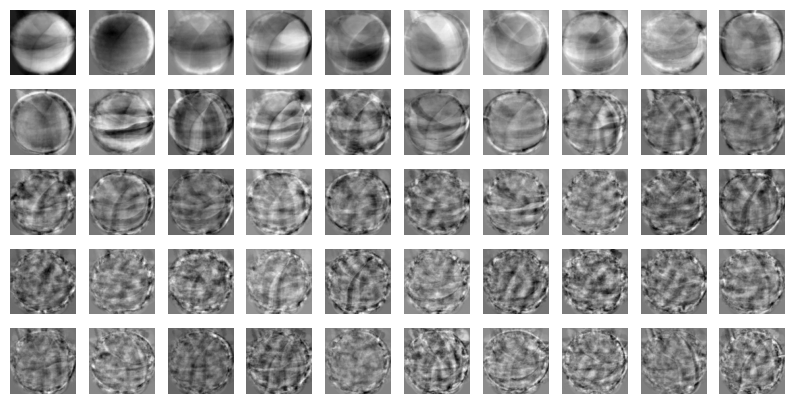

In [5]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

- 이 주성분은 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것
- 원본 데이터를 주성분에 투영하여 특성의 개수를 10000개에서 50개로 줄이기

In [6]:
# PCA의 transform() 메서드 사용
print(fruits_2d.shape)

fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 10000)
(300, 50)


## 원본 데이터 재구성

In [7]:
# 50개의 차원으로 축소한 fruits_pca 데이터의 10000개 특성 복원
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


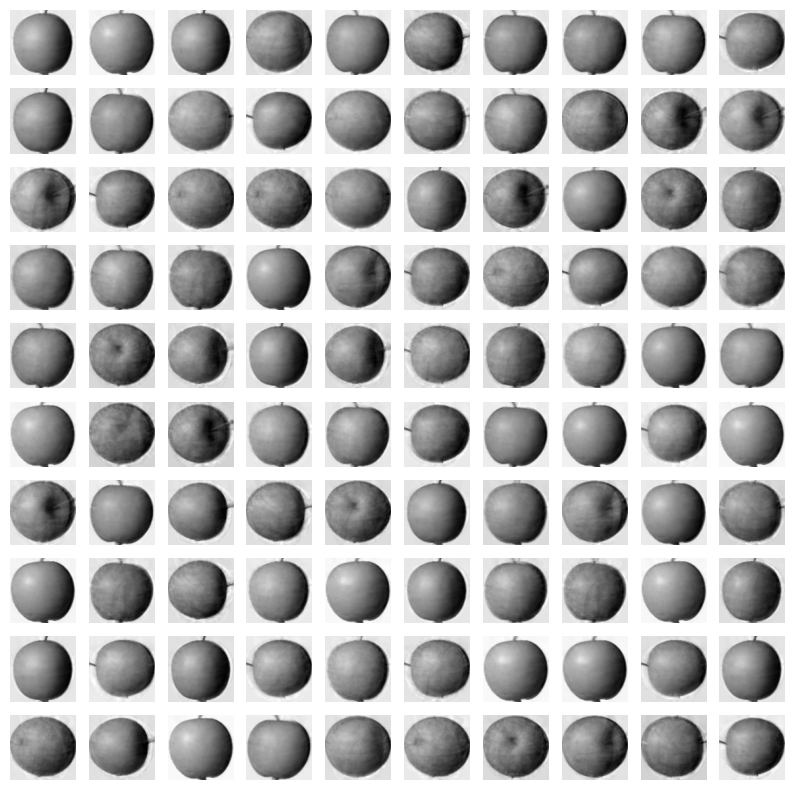

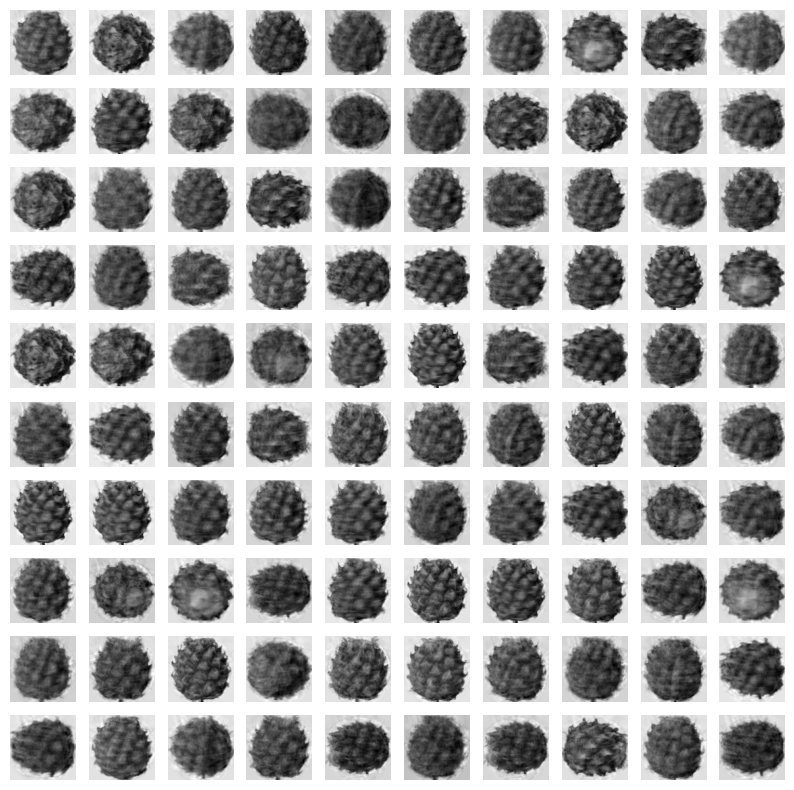

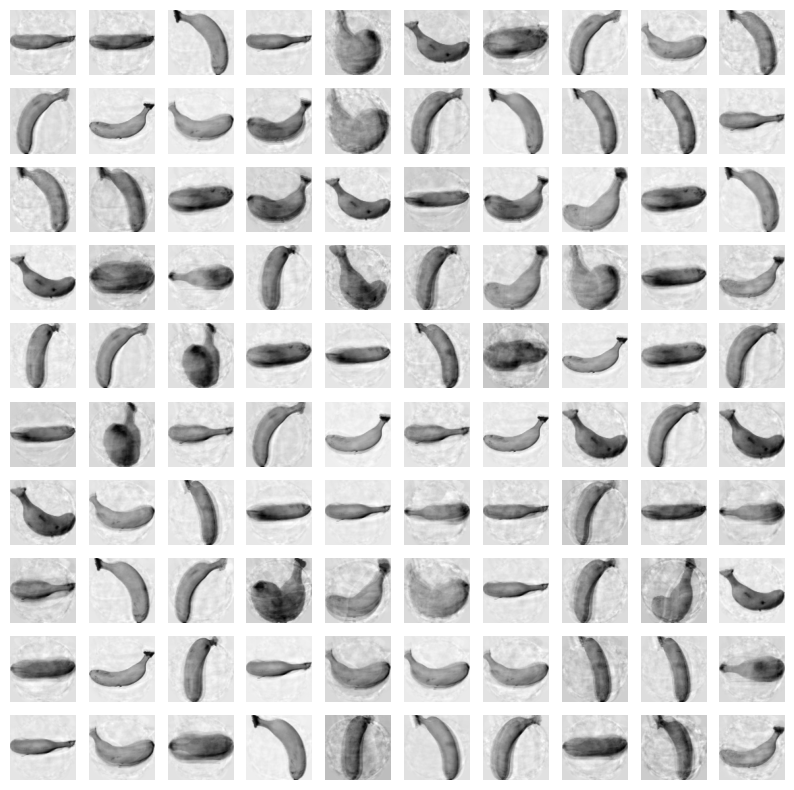

In [8]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

## 설명된 분산
- 주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값
- PCA 클래스의 explained_variance_ratio_에 각 주성분의 설명된 분산 비율이 기록되어있다.
- 분산 비율을 모두 더하면 50개의 주성분으로 표현하고 있는 총 분산 비율을 얻을 수 있음

In [9]:
print(np.sum(pca.explained_variance_ratio_))

0.9215266938391379


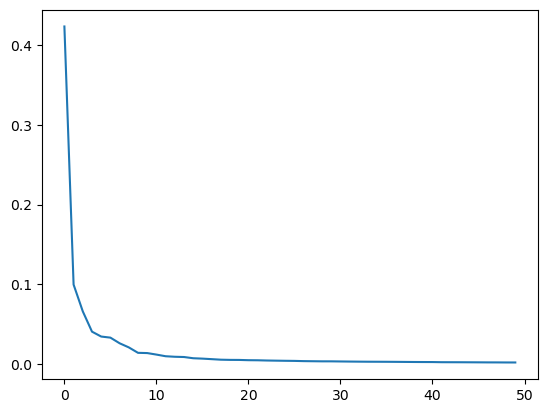

In [10]:
# 설명된 분산 그래프
plt.plot(pca.explained_variance_ratio_)
plt.show()

- 처음 10개의 주성분이 대부분의 분산을 표현

## 다른 알고리즘과 함께 사용하기

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

- 지도 학습 모델을 사용할면 타깃값이 있어야함
- 사과를 0, 파인애플을 1, 바나나를 2로 지정

In [12]:
target = np.array([0]*100 + [1]*100 + [2]*100)

In [13]:
# 원본 데이터 fruits_2d 사용
# 로지스틱 회귀 모델에서 성능을 가늠해 보기 위해 교차 검증 수행
from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.42488412857055663


In [14]:
# PCA로 축소한 fruits_pca 사용
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.006820869445800781


- 50개의 특성만 사용했을 때 정확도 100%, 훈련시간 20배 이상 감소
- PCA로 훈련 데이터의 차원을 축소하면 저장 공간 뿐만 아니라 머신러닝 모델의 훈련 속도도 높일 수 있다.

In [15]:
# 설명된 분산의 50%에 달하는 주성분을 찾는 PCA 모델
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [16]:
print(pca.n_components_) 

2


- 2개의 특성으로 원본 데이터에 있는 분산의 50% 표현 가능

In [17]:
# 원본 데이터 변환, 변환된 데이터의 크기는 (300, 2)
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [18]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.016578292846679686


- 2개의 특성을 사용함, 정확도 99%

In [20]:
# 차원 축소된 데이터를 사용해 k-평균 알고리즘으로 클러스터 찾기
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2]), array([110,  99,  91], dtype=int64))


- fruits_pca로 찾은 클러스터는 각각 110개, 99개, 91개의 샘플 포함

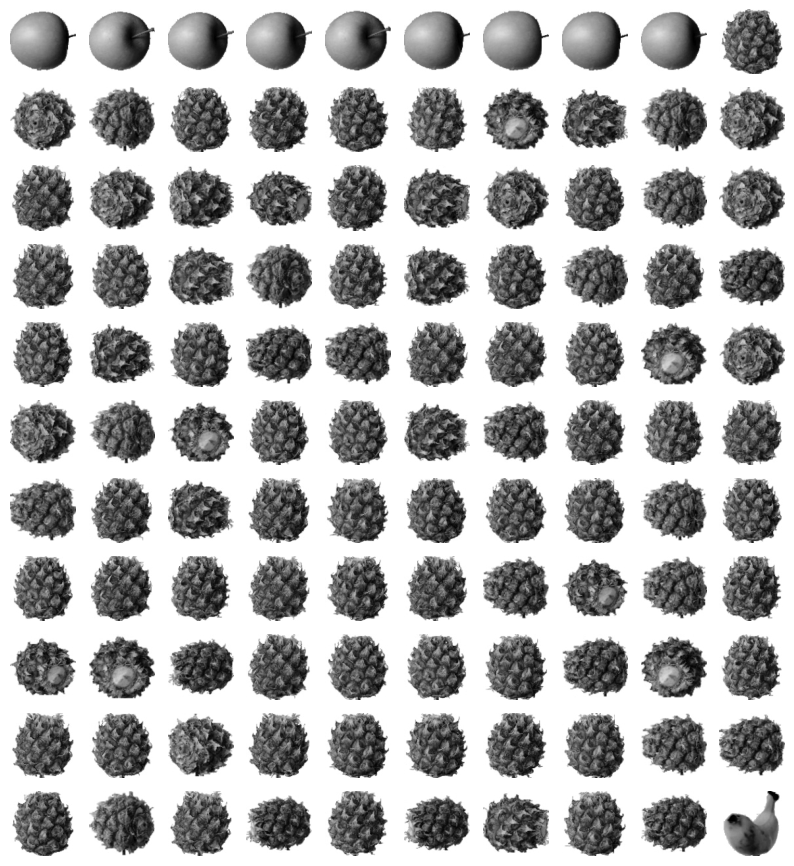

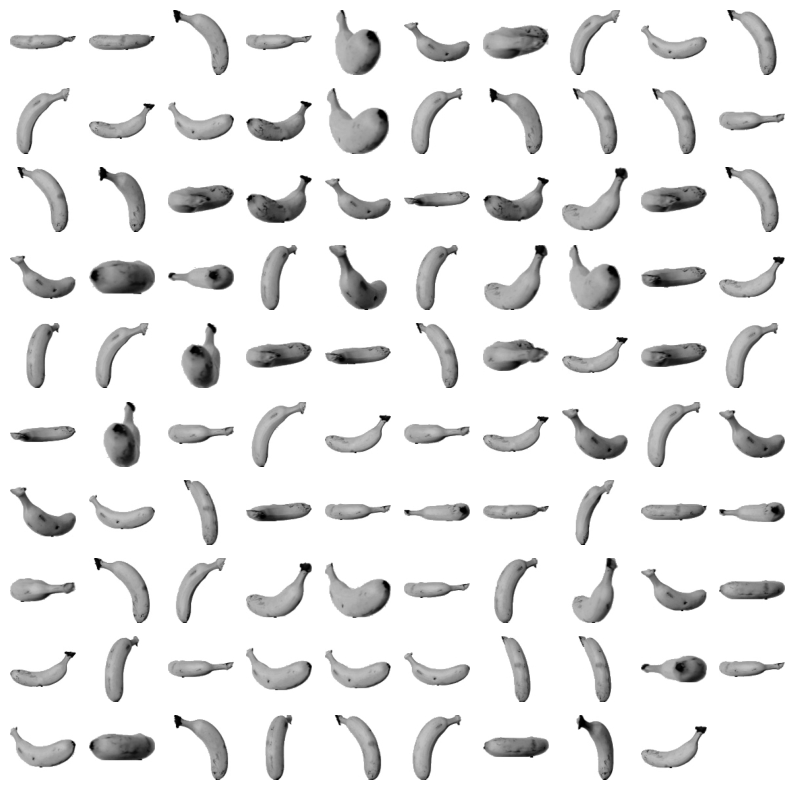

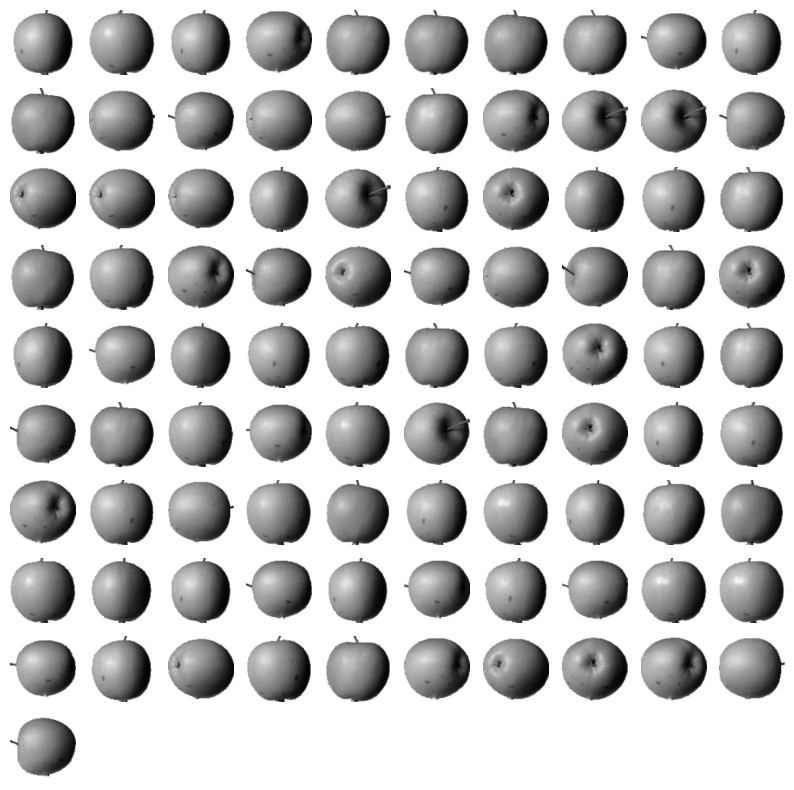

In [21]:
# KMeans가 찾은 레이블을 사용해 과일 이미지 출력
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

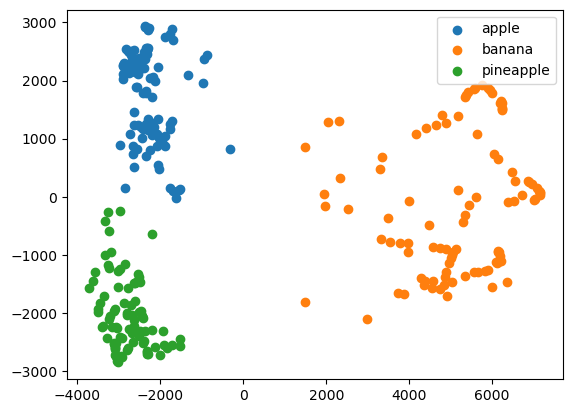

In [22]:
# km.labels_를 사용해 클러스터 별로 나누어 산점도 그리기
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()